In [70]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import tensorflow_decision_forests as tfdf


In [86]:
dataset = pd.read_csv('train.csv')

size = len(dataset)

columns = []
counts = []

for column in dataset:
    count = dataset[column].isna().sum()
    columns.append(column)
    counts.append(count/size*100)
    if count/size > 0.45:
        dataset = dataset.drop(column, axis=1)


# dataset = dataset.dropna()

# Alley - 93.76
# MasVnrType - 59.72
# FireplaceQu - 47.2
# PoolQC - 99.5
# Fence - 80.7
# MiscFeature - 96.3



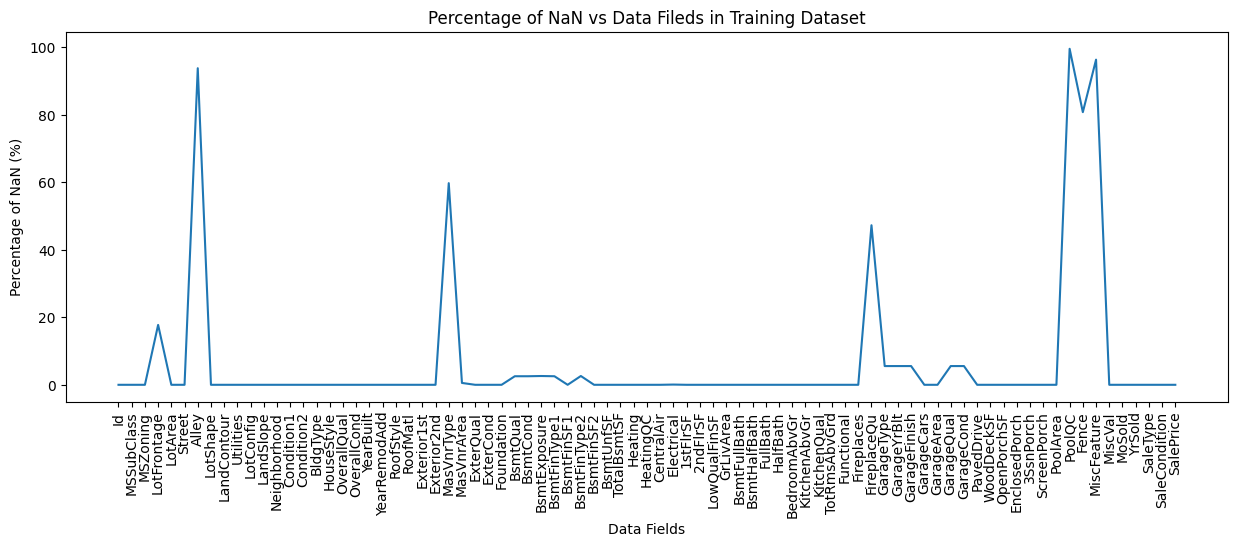

In [77]:
plt.figure().set_figwidth(15)
plt.plot(columns, counts)

plt.xlabel('Data Fields')
plt.ylabel('Percentage of NaN (%)')

plt.xticks(np.arange(len(columns)), columns, rotation=90)
plt.title("Percentage of NaN vs Data Fileds in Training Dataset")
plt.show()